In [2]:
include("./BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

train_data = WIDER_Data(wf_path * "train/")
print("WIDER Data is read. Total images: ", train_data.num_files, " & Total Faces: ", train_data.num_faces, '\n')

LoadError: MethodError: no method matching WIDER_Data(::String)
Closest candidates are:
  WIDER_Data(::Any, !Matched::Any; batch_size, train, shuffle, dtype) at /scratch/users/baristopal20/retinaface/BBTNet/datasets/WIDERFACE.jl:20

In [ ]:
include("./BBTNet/datasets/WIDERFACE.jl")

(imgs, boxes), state = iterate(train_data)
print("Got the first batch: ", size(imgs))

In [ ]:
include("./BBTNet/utils/ImageReader.jl")

train_reader = Image_Reader(true)
test_reader = Image_Reader(false)

filename = "0--Parade/0_Parade_marchingband_1_799.jpg"
img, bboxes = read_img(train_reader, root_dir * "train/images/" * filename, train_data.bboxes[filename], 640)
print("Image file is read: ", filename, '\n')

In [ ]:
include("./BBTNet/utils/draw.jl")

draw_boxes_and_landmarks(img, bboxes)

## Running The Model

In [ ]:
include("./BBTNet/models/retinaface.jl")

# atype = KnetArray{Float32}
atype = Array{Float32}

x = convert(atype, rand(640, 640, 3, 2))
model = RetinaFace(dtype=atype)

c, b, l = model(x, train=false)
print(size(c), " & ", size(b), " & ", size(l), " \n")

In [ ]:
include("BBTNet/models/retinaface.jl")
include("BBTNet/datasets/WIDERFACE.jl")
include("./BBTNet/utils/draw.jl")
include("./BBTNet/utils/box_processes.jl")

atype = KnetArray{Float32}
# atype = Array{Float32}
images_folder_dir = "../Datasets/WIDERFACE/WIDER_"

val_data = WIDER_Data(images_folder_dir * "val/", train=false, batch_size=2)
(imgs, boxes), state = iterate(val_data)
print("Got the first batch: ", size(imgs), "\n")

model = RetinaFace(dtype=atype)
imgs_permuted = convert(atype, permutedims(imgs, (3,2,1,4)))
c, b, l = model(imgs_permuted, train=false)

combined = permutedims(cat(b[1], l[1], dims=2), (2, 1))

draw_boxes_and_landmarks(imgs[:,:,:,1], combined)

In [ ]:
using JLD2
using FileIO

@save "retinaface_rand.jld2" model
model_dict = load("retinaface_rand.jld2")
model2 = model_dict["model"]
print("Model is loaded from a file!\n")

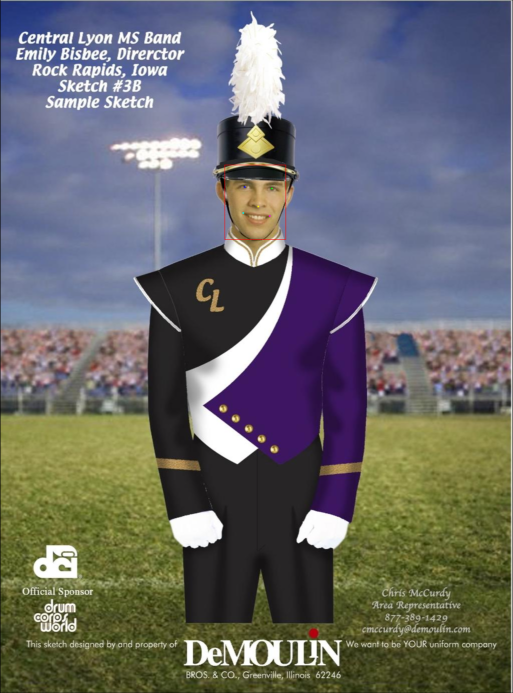

In [10]:
using Images

include("./BBTNet/utils/draw.jl")

data = reshape([449 330 122 149 488.906 373.643 542.089 376.442 515.031 412.83 485.174 425.893 538.357 431.491], (14, 1))
path = wf_path * "train/images/0--Parade/0_Parade_marchingband_1_849.jpg"

img = channelview(load(path))
draw_boxes_and_landmarks(img, data)

In [15]:
include("./BBTNet/utils/ImageReader.jl")

rotated = reverse(img, dims=3)
# colorview(RGB, float.(rotated))
size(img)

(3, 1385, 1024)

In [ ]:
import Pycall

@pyimport numpy 
@pyimport torch